In [16]:
import numpy as np  # Fast C++ arrays
import matplotlib.pyplot as plt  # Main visualisation package
import seaborn as sns  # Extension for visualization

from scipy.stats import laplace, norm, skewnorm, ttest_ind  # Distribution functions and T-test
from scipy.interpolate import interp1d  # Interpolation function
from scipy.integrate import quad # Numerical integration function

# Adjust the size of the figure
fig_size = [8, 6]  
plt.rcParams["figure.figsize"] = fig_size
sns.set(color_codes=True)

In [10]:
from tqdm import tqdm_notebook as tqdm

In [11]:
n_samples_array = np.arange(2,20,2)
n_simulations = 10000

In [12]:
class Bimodal_norm():
    """
    Bimodal distribution consisting of two normal distributions.
    """
    def __init__(self, mu1=2, sigma1=1, coef1=0.5, mu2=-2, sigma2=1):
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.coef1 = coef1
        self.mu2 = mu2
        self.sigma2 = sigma2
        self.x = np.linspace(-15, 15, 1000)
        
        cdf = self.coef1*norm.cdf(self.x, loc=self.mu1, scale=self.sigma1) + (1-self.coef1)*norm.cdf(self.x, loc=self.mu2, scale=self.sigma2)        
        self.mean = self.coef1*norm.mean(loc=self.mu1, scale=self.sigma1) + (1-self.coef1)*norm.mean(loc=self.mu2, scale=self.sigma2)
        self.cdf = interp1d(self.x, cdf)
        self.ppf = interp1d(cdf, self.x)        
        self.pdf = interp1d(self.x, np.gradient(self.cdf(self.x)))

def prepare_skewnorm_quantile(mu, sigma, alpha):
    """
    Prepares the skewed normal distribution quantile function by interpolating several values. 
    """
    uniform_values = np.linspace(0.01, 0.99, 10)
    percent_point = skewnorm.ppf(uniform_values, alpha, loc=mu, scale=sigma)
    return interp1d(uniform_values, percent_point, kind="cubic")

def count_significance_frequency(n, model):
    """
    Counts the value of the function for the main graph. 
    In this case, the test compares the distribution function with itself.
    """
    p_values = np.array([ttest_ind(
        model(np.random.uniform(0.01, 0.99, n)),
        model(np.random.uniform(0.01, 0.99, n))
    )[1] for _ in range(n_simulations)])
    return (len(p_values[p_values < 0.05])/len(p_values))*100

def count_significance_frequency_2(n, model1, model2):
    """
    Counts the value of the function for the main graph, taking the sample size as an argument. 
    In this case, the test compares the distribution function with another function.
    """
    p_values = np.array([ttest_ind(
        model1(np.random.uniform(0.01, 0.99, n)),
        model2(np.random.uniform(0.01, 0.99, n))
    )[1] for _ in range(n_simulations)])
    return (len(p_values[p_values < 0.05])/len(p_values))*100

def prepare_xy(model1, model2=None):
    """
    Applies count_significance_frequency or count_significance_frequency_2 function 
    for all sample sizes.
    """
    if model2 is None:
        return n_samples_array, np.array([count_significance_frequency(n, model1) for n in n_samples_array])
    else:
        return n_samples_array, np.array([count_significance_frequency_2(n, model1, model2) for n in n_samples_array])

In [15]:
mu = 0
sigma = 1
alpha = 4

binorm = Bimodal_norm()

print(
    norm.mean(loc=mu, scale=sigma),
    skewnorm.mean(sigma, alpha),
    laplace.mean(loc=mu, scale=sigma),
    binorm.mean
    )

models = [
    lambda x: norm.ppf(x, loc=mu, scale=sigma),  # normal distribution model
    prepare_skewnorm_quantile(mu, sigma, alpha),  # skewed-normal distribution model
    lambda x: laplace.ppf(x, loc=mu, scale=sigma),
    lambda x: binorm.ppf(x)  # distribution model 
]

0.0 4.564189583547757 0.0 0.0


In [88]:
df = np.zeros([len(models), 2, n_samples_array.shape[0]])

for i in tqdm(range(len(models))):
    x, y = prepare_xy(models[i])
    df[i, 0, :] = x
    df[i, 1, :] = y

In [89]:
ax = sns.lineplot(df[0, 0, :], df[0, 1, :], label="Normal ($\mu$ = 0; $\sigma$ = 1)")
ax1 = sns.lineplot(df[1, 0, :], df[1, 1, :], label="Skewed Normal ($\mu$ = 0; $\sigma$ = 1; $\\alpha$ = 2)")
ax3 = sns.lineplot(df[3, 0, :], df[3, 1, :], label="Binomial ($\mu$ = -2, 2; $\sigma$ = 1, 1)")
ax4 = plt.hlines(y=5, xmin=0, xmax=100, color='red', label="Significance level", linestyles="dotted")

ax.legend()
ax.set_title("Distribution Effect")
ax.set_xlabel("Number Of Samples")
ax.set_ylabel("p < 0.05 Frequency ")
plt.axis([1.9, 48, 0, 100])
plt.gcf().autofmt_xdate()
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

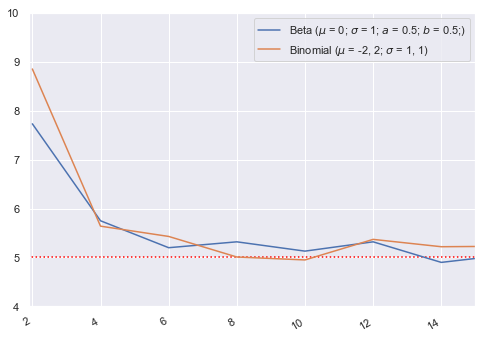

In [91]:
ax = sns.lineplot(df[0, 0, :], df[0, 1, :], label="Normal ($\mu$ = 0; $\sigma$ = 1)")
ax1 = sns.lineplot(df[1, 0, :], df[1, 1, :], label="Skewed Normal ($\mu$ = 0; $\sigma$ = 1; $\\alpha$ = 2)")
ax2 = sns.lineplot(df[0, 0, :], df[0, 1, :], label="Beta ($\mu$ = 0; $\sigma$ = 1; $a$ = 0.5; $b$ = 0.5;)")
ax3 = sns.lineplot(df[1, 0, :], df[1, 1, :], label="Binomial ($\mu$ = -2, 2; $\sigma$ = 1, 1)")
ax4 = plt.hlines(y=5, xmin=0, xmax=100, color='red', label="Significance level", linestyles="dotted")

ax.legend()
ax.set_title("Distribution Effect")
ax.set_xlabel("Number Of Samples")
ax.set_ylabel("p < 0.05 Frequency ")
plt.axis([1.9, 15, 4, 10])
plt.gcf().autofmt_xdate()
plt.show()